## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


## Set Data path

In [2]:
datadir = os.path.expanduser('~/Dev/humpbackwhale/data')
pretrainedmodeldir = os.path.expanduser('~/Dev/humpbackwhale/pretrainedmodels')
os.listdir(os.path.expanduser(datadir))

['.DS_Store',
 'test',
 'data.zip',
 'trainexcel.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [3]:
train_df = pd.read_csv(datadir + '/train.csv')
#train_df = train_df[:500]
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img(datadir+"/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.astype('float32')/255
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [5]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [6]:
X = prepareImages(train_df, train_df.shape[0], "train")
#X /= 100
X.shape

Preparing images
('Processing image: ', 1, ', ', '0000e88ab.jpg')
('Processing image: ', 501, ', ', '04c72257b.jpg')
('Processing image: ', 1001, ', ', '09cacb84d.jpg')
('Processing image: ', 1501, ', ', '0ef961892.jpg')
('Processing image: ', 2001, ', ', '141b56a1a.jpg')
('Processing image: ', 2501, ', ', '199a417aa.jpg')
('Processing image: ', 3001, ', ', '1ec170983.jpg')
('Processing image: ', 3501, ', ', '23f084b93.jpg')
('Processing image: ', 4001, ', ', '29163ad0b.jpg')
('Processing image: ', 4501, ', ', '2e0fab120.jpg')
('Processing image: ', 5001, ', ', '3347515d9.jpg')
('Processing image: ', 5501, ', ', '3842d71dc.jpg')
('Processing image: ', 6001, ', ', '3d7f4c7d5.jpg')
('Processing image: ', 6501, ', ', '425f763ca.jpg')
('Processing image: ', 7001, ', ', '4714400cd.jpg')
('Processing image: ', 7501, ', ', '4c082fbdf.jpg')
('Processing image: ', 8001, ', ', '50c683e23.jpg')
('Processing image: ', 8501, ', ', '560d986ad.jpg')
('Processing image: ', 9001, ', ', '5b68c83ed.jpg')

(25361, 100, 100, 3)

In [7]:
y, label_encoder = prepare_labels(train_df['Id'])


/Users/marcelschneider/anaconda3/envs/humpbackwhale/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y.shape

(25361, 5005)

In [182]:
def CNN_Simple(): 
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(Flatten())
    model.add(Dense(500, activation="relu", name='rl'))
    model.add(Dropout(0.8))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

### Transfer Learning

In [183]:
bottleneck_features = np.load(pretrainedmodeldir+"/DogResnet50Data.npz")
train_Resnet50 = bottleneck_features['train']
test_Resnet50 = bottleneck_features['test']

def resnet_model(trainbottleneckfeatures):
    model = Sequential()
    
    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(GlobalAveragePooling2D(input_shape=trainbottleneckfeatures.shape[1:]))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

In [184]:
print(train_Resnet50.shape[1:])
print(X.shape)
#model = resnet_model(train_Resnet50)
model = CNN_Simple()
history = model.fit(X, y, epochs=5, batch_size=100, verbose=1)
gc.collect()

(1, 1, 2048)
(25361, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15

106

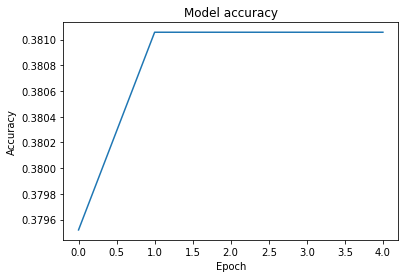

In [185]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [186]:
predictions = model.predict(np.array(X), verbose=1)


25361/25361 [==============================] - 100s 4ms/step


In [187]:
#print([label_encoder.inverse_transform(predictions[0].argsort()[-5:][::-1])])
#print(label_encoder.inverse_transform(predictions[1].argsort()[-5:][::-1]))

In [188]:
pred_df = copy.copy(train_df)
#print(pred_df.describe)
for i, pred in enumerate(predictions):
    #print(pred)
    #ToDo Prediction array erstellen
    #print(i)label_encoder.inverse_transform(pred.argsort()[-5:][::-1]
    #print(i)
    #print(pred)
    #print(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))
    #print(pred.argsort()[-5:])
    pred_df.loc[i, 'Id'] = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])#, label_encoder.inverse_transform(pred.argsort()[-4:-4][::-1], label_encoder.inverse_transform(pred.argsort()[-3:-3][::-1]), label_encoder.inverse_transform(pred.argsort()[-2:-2][::-1])), label_encoder.inverse_transform(pred.argsort()[-1:-1][::-1])]
    #test_df.loc[i, 'Id2'] = ', '.join(label_encoder.inverse_transform(pred.argsort()[-4:-3][::-1]))
    #print(type(test_df.loc[i, 'Id'][0][0]))

In [58]:
print(pred_df.head(10))
#pred_df.to_csv('submission.csv', index=False)

           Image                                                 Id
0  0000e88ab.jpg  [new_whale, w_0369a5c, w_9c506f6, w_564a34b, w...
1  0001f9222.jpg  [new_whale, w_23a388d, w_9b5109b, w_3de579a, w...
2  00029d126.jpg  [new_whale, w_700ebb4, w_3de579a, w_23a388d, w...
3  00050a15a.jpg  [new_whale, w_23a388d, w_9b5109b, w_9c506f6, w...
4  0005c1ef8.jpg  [new_whale, w_0369a5c, w_9c506f6, w_564a34b, w...
5  0006e997e.jpg  [new_whale, w_0369a5c, w_564a34b, w_d405854, w...
6  000a6daec.jpg  [new_whale, w_d405854, w_564a34b, w_23a388d, w...
7  000f0f2bf.jpg  [new_whale, w_3de579a, w_9b5109b, w_700ebb4, w...
8  0016b897a.jpg  [new_whale, w_23a388d, w_9b5109b, w_9c506f6, w...
9  001c1ac5f.jpg  [new_whale, w_9b5109b, w_23a388d, w_789c969, w...


### Evaluation of Prediction Precision

In [175]:
class myarray(np.ndarray):
    def __new__(cls, *args, **kwargs):
        return np.array(*args, **kwargs).view(myarray)
    def index(self, value):
        return np.where(self == value)

    
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """   
    print("label: {}".format(label))
    print("predictions: {}".format(predictions))
#    print(predictions[:5])
#    print(predictions[2])

    score = 0.0
    try:
        print("try")
        #score =  (1/float(predictions[:5].index(label) + 1))
        #print("np where {}".format(np.where(predictions == label)[0]))
        print(len(np.where(predictions == label)[0])==0)
        if not len(np.where(predictions == label)[0])==0:
        

            score =  1.0/(float(np.where(predictions == label)[0]) + 1)
            print("score: {}".format(score))
            return score
        else:
            return 0.
            
    except ValueError:
        print("except")
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])


In [176]:
#                   (true, [predictions])
#assert map_per_image('xy', []) == 0.0
#assert map_per_image('xy', ['yx']) == 0.0
#assert map_per_image('xy', ['xy']) == 1.0
#assert map_per_image('x', ['x', 'y', 'z']) == 1.0
#assert map_per_image('x', ['y', 'x']) == 0.5
#assert map_per_image('x', ['y', 'x', 'x']) == 0.5
#assert map_per_image('x', ['y', 'z']) == 0.0
#assert map_per_image('x', ['y', 'z', 'x']) == 1.0/3.0
#assert map_per_image('x', ['y', 'z', 'a', 'b', 'c']) == 0.0
#assert map_per_image('x', ['x', 'z', 'a', 'b', 'c']) == 1.0#
#assert map_per_image('x', ['y', 'z', 'a', 'b', 'x']) == 1./5.
#assert map_per_image('x', ['y', 'z', 'a', 'b', 'c', 'x']) == 0.0

#assert map_per_set(['x'], [['x', 'y']]) == 1.0
#assert map_per_set(['x', 'z'], [['x', 'y'], ['x', 'y']]) == (1./2.)
#assert map_per_set(['x', 'z'], [['x', 'y'], ['x', 'y', 'z']]) == 2./3.
#assert map_per_set(['x', 'z', 'k'], [['x', 'y'], ['x', 'y', 'z'], ['a', 'b', 'c', 'd', 'e']]) == 4./9.


In [177]:
train_df.head()


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [180]:
#map_per_set(labels, predictions)

totalaccuracy = 0.
#print(test_df.head)
#test_df = test_df[0:500]
print(type(pred_df))
totalaccuracy = map_per_set(train_df['Id'],pred_df['Id'])
#for id, prediction in enumerate(predictions):
#    #print("ID: {}, Istwert: {}; Prediction: {}".format(id, train_df.at[id,'Id'], pred_df.at[id,'Id']))
#    totalaccuracy += map_per_image(train_df.at[id,'Id'],pred_df.at[id,'Id'])
    
print(totalaccuracy/len(pred_df.index))

<class 'pandas.core.frame.DataFrame'>
label: w_f48451c
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_c3d896a
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_20df2c5
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
False
score: 1.0
label: w_dd88965
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_64404ac
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
True
label

try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_68ed1f9
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_564a34b']
try
True
label: w_78e229f
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_302799d
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_2b069ba']
try
True
label: w_564a34b
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 0.25
label: w_66e3287
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_99af1a9
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_4690940
pred

score: 1.0
label: w_abf0b13
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_3108dce
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_d140497
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_20ad973
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_94a0d4e
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_3de579a' 'w_9c506f6']
try
True
label: w_88bb921
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_9c506f6']
try
True
label: w_e99e430
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_2fc775e
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_60ce6fc
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' '

True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_58afeb2
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
False
score: 1.0
label: w_6e6307e
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_e9cf335
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_fb98d50
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_16df050
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_576026e
predictions: ['new_wh

True
label: w_d6d89ed
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_fd3e556
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 0.2
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_3a333ae
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
True
label: w_5645ed1
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_f35e494
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_bece5a4
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_88e4cbf
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de5

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_3a34d6f
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_0369a5c' 'w_564a34b' 'w_9c506f6']
try
False
score: 1.0
label: w_94e8c02
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: w_dd944b7
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_49afbc9
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
True
label: w_cd99382
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_2e4cb98
predictio

predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_51e7506
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_10f3b75
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_e4b4611
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_c014421
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: w_c1d2d7f
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_f0fe284
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_2b50adf
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d4

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_910831a
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: w_b9e5911
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_2b069ba']
try
True
label: w_27d6aac
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_f61b957
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_8c25681']
try
True
label: w_f0eddab
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
False
score: 1.0
label: w_21b2790
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_wh

predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_2b069ba']
try
False
score: 1.0
label: w_ca11f46
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_6cda039
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
True
label: w_dab2353
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_d405854' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_9cc2050
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_2ed0d2f
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_a3d2008
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: w_53215c6
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3d

predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_789c969' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: w_0887d9b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_efa6b4a
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_69c06ad
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
False
score: 1.0
label: w_9634512
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b

predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: w_5482351
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_a7067d1
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_78e229f
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_8a56270
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_3fb99a3
predictions: ['new_whale' 'w_9c506f6' 'w_70

label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_691b684
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_e9e413e
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_cc1784d
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_9472e22
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: [

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_9a1a810
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_43fa7fc
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
True
label: w_34ecf36
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_9142b9c
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_0b398b2
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_f9d1114
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_8f424c5
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_9b5109b
predictions: ['new_whale' 'w_d405

label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_6822dbc
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_6e0a45b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_3e4b155
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_17b0d3a
pr

False
score: 1.0
label: w_736cca3
predictions: ['new_whale' 'w_564a34b' 'w_0369a5c' 'w_d405854' 'w_9c506f6']
try
True
label: w_8c25681
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: w_700ebb4
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_7272aa5
predictions: ['new_whale' 'w_700ebb4' 'w_9c506f6' 'w_3de579a' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: w_89f60

predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_c073f96
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_4bbd0fd
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
True
label: w_4c07458
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_0369a5c']
try
False
score: 1.0
label: new_whale
predictions: ['new_

True
label: w_aee6701
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_a8c2847
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
True
label: w_91cc02c
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_a8c2847
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: w_6cfa650
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_5116e7e
predictions: ['new_whale' 'w_23a388d' 'w_9c506f6' 'w_9b5109b' 'w_0369a5c']
try
True
label: w_11ff425
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_8c25681' 'w_700ebb4']
try
True
label: w_3de579a
predictions: ['new_whale' 'w_9b5109b' 'w_23a3

label: w_78de8f7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_e966f36
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_d405854
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 0.5
label: w_4a1b777
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_fe15413
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_3de579a']
try
True
label: w_5c51475
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_a61a47c
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_3de579a' 'w_9c506f6']
try
True
label: w_6279534
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 

try
True
label: w_62c78f3
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_bdded04
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_db86325
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_a88c767
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_7c77c5c
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_f0a5983
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: w_8fd3810
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_27597ff
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_0ea7436
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_

True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_8c25681' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_b1f637e
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: w_04acf95
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_bfe77d0
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_03a82c1
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_8c25681' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: w_3b03245
predictio

try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_d9cdc09
predictions: ['new_whale' 'w_700ebb4' 'w_9c506f6' 'w_8c25681' 'w_3de579a']
try
True
label: w_2365d55
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_b86917d
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_3904956
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_2644b11
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_fcf1d68
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: w_4b4f9b7
predictions: ['new_whale' 'w_

True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_c6c89db
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_f449c3d
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_e71f9c7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_04f5f55
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_207f153
predictions: ['new_whale' 'w_700ebb4' 'w_9c506f6' 'w_23a388d' 'w_3de579a']
try
True
label: w_deda5f7
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_b330c85
predictions: ['new_whale' 'w_23a3

predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
True
label: w_7d296e9
predictions: ['new_whale' 'w_9b5109b' 'w_d405854' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
False
score: 1.0
label: w_4f3dc75
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_456646a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_f5a7f03
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_d4

False
score: 1.0
label: w_e9e413e
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_80b474e
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_9fc06d4
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
True
label: w_f0eddab
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_f971ecb
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_2b069ba
predictio

label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_d405854' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_62b631e
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_3a241cf
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_90336d0
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_8c25681' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_8a6a8d5
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: [

predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_e0f4a42
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
True
label: w_7cb0e92
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
False
score: 1.0
label: w_2df85e7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_e9b4719
predictions: ['new_whale' 'w_d4

try
True
label: w_8d4c9f7
predictions: ['new_whale' 'w_9b5109b' 'w_d405854' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_260a2e7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_11e90bc
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_c87817e
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_0a2e1ef
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_9b5109b']
try
True
label: w_46c49e8
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_5b227ec
predictions: ['new_whale' 'w_564a34b' 'w_23a388d' 'w_d405854' 'w_0369a5c']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_

label: w_f128a4d
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_a3cbe89
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_b938e96
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9c506f6' 'w_9b5109b']
try
True
label: w_1275240
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_90c9763
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_9b5109b']
try
True
label: w_4ea4f59
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_9c506f6
predictions: ['new_whale' 'w_0369a5c' 

label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_0369a5c' 'w_9b5109b']
try
False
score: 1.0
label: w_7ae9946
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_b1e0959
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_9714922
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_cef693e
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_23a388d']
try
False
score: 1.0
label: w_7e579dd
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_700ebb4' 'w_0369a5c']
try
False
score: 1.0
label: w_e6d9cdd
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 

label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_b019a50
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_9e33316
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_ce5c5eb
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_0f8b8e2
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_1887b5a
predictions: [

try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: w_3feca90
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_b3ca4b7
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_ac835f9
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_a6d6964
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_9c506f6
predi

try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_4a1b689
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_ad88c85
predictions: ['new_whale' 'w_d405854' 'w_0369a5c' 'w_564a34b' 'w_9c506f6']
try
True
label: w_2fc317c
predictions: ['new_whale' 'w_700ebb4' 'w_9c506f6' 'w_3de579a' 'w_23a388d']
try
True
label: w_a86c082
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
True
label: w_f57140c
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_fe54484
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_23a388d' 'w_9b5109b' 'w_700ebb4']
try
False
score: 1.0
label: w_a9822dd
predictions: ['new_whale' 'w_

try
True
label: w_007fefa
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_f602022
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_8c25681']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_e2a09d4
predictions: ['new_whale' 'w_0369a5c' 'w_d405854' 'w_564a34b' 'w_9c506f6']
try
True
label: w_dea042e
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_9b5109b']
try
True
label: w_1032bb6
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: w_f74a89e
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_

try
False
score: 1.0
label: w_2a6d5ee
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_712b916
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_ad3a043
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_c11f9d8
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_be4f189
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_1e3e9a7
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_2eec458
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_

label: w_99e4fe2
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_144ecb6
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_c97ad94
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_981baf4
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_6e6307e
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_564a34b' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
False
score: 1.0
label: w_563d4b1
predictions: ['new_whale' 

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_d405854' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_25085e0
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_3216236
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_3de579a' 'w_9b5109b']
try
False
score: 1.0
label: w_b3e445e
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: w_5e8e218
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_dae7ff7
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_2ff0834
predictio

label: w_0f8b8e2
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_d09a047
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_b8368f2
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
True
label: w_abf193d
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_0369a5c' 'w_564a34b' 'w_9c506f6']
try
False
score: 1.0
label: w_d875f4d
predictions: [

predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_0182687
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_0655a0d
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
True
label: w_069c25b
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: w_2137c6f
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
True
label: w_aa0dacc
predictions: ['new_whale' 'w_0369a5c' 'w_9c

score: 1.0
label: w_3de579a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 0.25
label: w_fa4034b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_60c073b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_d573a68
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_7ef8a85
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_0815d2c
pr

True
label: w_488865e
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_8e88f4f
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_4112f9a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_9a9a2c8
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
True
label: w_4c62681
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_a2f8488
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_9490369
predictions: ['new_whale' 'w_0369

try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_0369a5c' 'w_9b5109b']
try
False
score: 1.0
label: w_60ce6fc
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_5d1b1a7
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9b5109b' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_14b1427
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_0a155b9
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
True
label: w_f

label: w_d6f0be4
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_a0c732f
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_ca11f46
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_9b5109b']
try
True
label: w_5bef7cb
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_e2b0292
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
False
score: 1.0
label: w_69cce86
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
False
score: 1.0
label: w_53276a1
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_02545ea
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 

False
score: 1.0
label: w_b3cfa1d
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9c506f6']
try
False
score: 1.0
label: w_bff3c3b
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: w_69edff7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_74c924a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_716ac00
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_564a34b' 'w_9b5109b']
try
True
label: w_180e241
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_27597ff
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c50

predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_234713b
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_e129173
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_ddff916
predictions: ['new_whale' 'w_564a34b' 'w_0369a5c' 'w_9c506f6' 'w_23a388d']
try
True
label: w_dfc200b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_afb4a42
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_c0e27e9
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_4bc3d74
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd

True
label: w_f48451c
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
True
label: w_c0d11da
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_d16eb60
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_0369a5c']
try
True
label: w_190b9bb
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_51fc1fc
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
True
label: w_16b5050
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_1247b8c
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: w_b55fb6e
predictions: ['new_whale' 'w_d405854' 'w_564a

label: w_99e43ae
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_85d152a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_fd3e556
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_6822dbc
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_23a388d' 'w_9b5109b' 'w_700ebb4']
try
False
score: 1.0
label: w_d3b1733
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_3de579a' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_bfe77d0
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_9b5109b']
try
True
label: w_0ef790d
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 

predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_db68456
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_08d62ee
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_3de579a']
try
True
label: w_990921b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_

predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_6caff0f
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_1995d15
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: w_3f7d5f5
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_a113b33
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
True
label: w_698fcbe
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_0718183
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: w_1887b5a
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
True
label: w_f648d33
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9b5109b' 'w_3de579a']
try
False
score:

try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_a05181b
predictions: ['new_whale' 'w_23a388d' 'w_9c506f6' 'w_9b5109b' 'w_0369a5c']
try
True
label: w_69b5ace
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_e21b25f
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_9728637
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_cfcace7
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_564a34b']
try
True
label: w_2ff0834
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_

False
score: 1.0
label: w_1b1dd05
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_d14059c
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_72aa314
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_b870e44
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_d892cd9
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_23a388d' 'w_9b5109b']
try
True
label: w_e8e08e6
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_15951db
predictions: ['new_wh

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: w_e1f57e7
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_e6450bc
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_1133530
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_700ebb4' 'w_23a388d']
try
True
label: w_7f04b8b
predictions: ['new_whale' 'w_564a34b' 'w_0369a5c' 'w_9c506f6' 'w_23a388d']
try
True
label: w_242fb46
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: w_e2a09d4
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_cd6743e
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_6cda039
predictions: ['new_whale' 'w_3de5

label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_7f0d18a
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_9c506f6']
try
True
label: w_122e247
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_8c25681' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_4bf625b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_700ebb4' 'w_3de579a']
try
True
label: w_1c6465a
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_4516d31
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_564a34b']
try
True
label: w_99b7ba2
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_0e4b65e
predictions: ['new_whale' 'w_9b5109b' 

try
True
label: w_abc5af2
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_9c506f6
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_1083a05
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_c97ad94
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9b5109b' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_7769d46
predi

True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: w_298f605
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: w_7537a43
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
la

True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
False
score: 1.0
label: w_5b8f665
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_29a8580
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_45246db
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_7e579dd
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_190375b
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: w_84343d7
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_7707132
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_d405854
predictions: ['new_whale' 'w_9b5109b' 'w_23a3

try
True
label: w_b9373bc
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_ec32fa6
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_54ea24d
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_4e13e82
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_06fb64a
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_0369a5c' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: w_d9f8641
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_0369a5c']
try
True
label: w_99e43ae
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_45473b9
predictions: ['new_whale' 'w_d405854' 'w_

label: w_3eae264
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_c59d924
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_62db660
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_5e8e218
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_003bae6
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_564a34b']
try
True
label: w_e1ffbe2
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_a9304b9
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_564a34b']
try
True
label: w_fdc6e6d
predictions: ['new_whale' 'w_23a388d' 'w_9c506f6' 'w_9b5109b' 'w_0369a5c']
try
True
label: w_8c25681
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 

predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: w_726c717
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_5a3cd6d
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: w_fa2ec89
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_23ce00e
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_06292cd
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_4ab3420
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
True
label: w_c6b05f1
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_b9d5945
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try


label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_88eaa39
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_f353d20
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_7a1c290
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
pr

label: w_accb0cb
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: w_640a24a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_7938c79
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
True
label: w_b3cc7b3
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: w_2f67f0a
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_0ad0f5b
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_a113b33
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
True
label: w_81d4bd6
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 

try
False
score: 1.0
label: w_57e4b21
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_5ae026a
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
True
label: w_1ca9ab1
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_564a34b']
try
True
label: w_551165a
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: w_d

label: w_1e283bb
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_7c1435e
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_553d1ef
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_523fb3a
predictions: ['new_whale' 'w_23a388d' 'w_9c506f6' 'w_9b5109b' 'w_700ebb4']
try
True
label: w_efbdcbc
predictions: [

score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_700ebb4' 'w_9b5109b']
try
False
score: 1.0
label: w_53215c6
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: w_edce644
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_9c506f6']
try
False
score: 1.0
label: w_decafbd
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
True
label: w_0135f5f
predictions: ['new_whale' 'w_0369a5c' 'w_d405854' 'w_564a34b' 'w_9c506f6']
try
True
label: w_b4396ae
pre

predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: w_8a1b71c
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_23a388d']
try
False
score: 1.0
label: w_2362d7f
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_8585e34
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_d8d0dd9
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_d593be8
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_46ba1ce
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_82d50c5
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_9c506f6' 'w_700ebb4']
try
True
label: w_dc14a8e
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9b5109b' 'w_3d

predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_23a388d' 'w_0369a5c' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
False
score: 1.0
label: w_f8746c3
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
True
label: w_d13848b
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predict

label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: w_03670aa
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
True
label: w_52093cb
predictions: ['new_whale' 'w_d405854' 'w_0369a5c' 'w_564a34b' 'w_9c506f6']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_700ebb4' 'w_23a388d']
try
False
score: 1.0
label: w_af367c3
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_564a34b' 'w_d405854']
try
True
label: w_6e76427
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: [

predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: w_b037216
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: new_whale
predict

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_b1a3345
predictions: ['new_whale' 'w_9b5109b' 'w_3de579a' 'w_23a388d' 'w_700ebb4']
try
True
label: w_59052ad
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_37d2f3a
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_700ebb4' 'w_3de579a']
try
True
label: w_70a2a2f
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
False
score: 1.0
label: w_3c8f7da
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_d947e85
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_d0528f6
predictions: ['new_wh

try
False
score: 1.0
label: w_8fb247e
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_21bb5bd
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_46ccc6f
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_92eaff4
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_9e98f50
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
True
label: w_bfecb74
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_d405854']
try
True
label: w_5773c71
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_dd08014
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9c506f6']
try
False
score: 1.0
label: w_ff1de02
predictions: ['new_whale' 'w_d405854' 'w_

label: w_9b9602c
predictions: ['new_whale' 'w_23a388d' 'w_564a34b' 'w_d405854' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: w_9c506f6
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 0.333333333333
label: w_2e18226
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_57bc12e
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_27b7295
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: w_7d458aa
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_d603939
predictions: ['

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
False
score: 1.0
label: w_55fffeb
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_80bb6c7
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_3de579a']
try
True
label: w_a9304b9
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
True
label: w_9da1811
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_708c3d2
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_d405854']
try
False
score: 1.0
label: w_2964e0b
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: new_whale
predictions: ['new_wh

label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_564a34b' 'w_23a388d']
try
False
score: 1.0
label: w_00f340d
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_b19f2f9
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_564a34b']
try
True
label: w_1d0830e
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_d405854' 'w_3de579a']
try
False
score: 1.0
label: w_a3dc2bd
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_ae393cd
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_1260eb5
predictions: ['new_whale' 

False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: w_544128b
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_9c506f6' 'w_fd3e556']
try
False
score: 1.0
label: w_63b91aa
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_789c969']
try
False
score: 1.0
label: w_b950c88
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: w_4b143db
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_d405854
predictions: ['new_whale' 'w_0369a5c' 'w_564a34b' 'w_d405854' 'w_9c506f6']
try
False
score: 0.25
label: w_70e9661
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: new_whale
predicti

predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_05081a8
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_2972f31
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_f8b4ea9
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
True
label: w_af367c3
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_d405854' 'w_3de579a']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_23a388d']
try
False
score: 1.0
label: w_a47dc2d
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_56

label: w_5557f1e
predictions: ['new_whale' 'w_700ebb4' 'w_23a388d' 'w_9b5109b' 'w_3de579a']
try
True
label: w_1403973
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
True
label: w_f3b2948
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_84dbd14
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_3de579a' 'w_789c969']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
False
score: 1.0
label: new_whale
predictions: [

score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_dbf651b
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
False
score: 1.0
label: w_c9b4607
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_9da1811
predictions: ['new_whale' 'w_3de579a' 'w_9b5109b' 'w_23a388d' 'w_700ebb4']
try
True
label: w_1032bb6
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_2b069ba']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
False
score: 1.0
label: w_d3b48ef
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_564a34b' 'w_9b5109b']
try
False
score: 1.0
label: new_whale
predictions: ['

False
score: 1.0
label: w_bf960fa
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_564a34b']
try
True
label: w_c85ff1e
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_23a388d' 'w_8c25681']
try
True
label: w_65ffd7d
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_564a34b' 'w_9b5109b']
try
False
score: 1.0
label: w_b72cdc1
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: w_b7babc0
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_23a388d' 'w_9b5109b']
try
True
label: w_e2372d6
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_700ebb4' 'w_23a388d' 'w_3de579a']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_3de579a']
try
False
score: 1.0
label: w_6e7763b
predictions: ['new_wh

False
score: 1.0
label: w_5b463cf
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_789c969']
try
True
label: w_754cc34
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_9b5109b' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
False
score: 1.0
label: w_e2e7384
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: w_2b069ba
predictions: ['new_whale' 'w_d405854' 'w_23a388d' 'w_564a34b' 'w_9b5109b']
try
True
label: w_32e705d
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_2b069ba' 'w_564a34b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_564a34b' 'w_0369a5c' 'w_9c506f6']
try
False
score: 1.0
label: w_7091e67
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: new_whale
predictions: ['new_wh

predictions: ['new_whale' 'w_564a34b' 'w_23a388d' 'w_0369a5c' 'w_9c506f6']
try
True
label: w_f765256
predictions: ['new_whale' 'w_23a388d' 'w_9b5109b' 'w_3de579a' 'w_700ebb4']
try
True
label: w_2807565
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
True
label: w_7860ed5
predictions: ['new_whale' 'w_0369a5c' 'w_9c506f6' 'w_564a34b' 'w_fd3e556']
try
True
label: new_whale
predictions: ['new_whale' 'w_9c506f6' 'w_0369a5c' 'w_23a388d' 'w_700ebb4']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_3de579a' 'w_700ebb4' 'w_9b5109b' 'w_23a388d']
try
False
score: 1.0
label: w_9af432a
predictions: ['new_whale' 'w_9b5109b' 'w_23a388d' 'w_789c969' 'w_d405854']
try
True
label: w_fe15413
predictions: ['new_whale' 'w_700ebb4' 'w_3de579a' 'w_23a388d' 'w_9b5109b']
try
True
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23a388d' 'w_564a34b']
try
False
score: 1.0
label: new_whale
predictions: ['new_whale' 'w_d405854' 'w_9b5109b' 'w_23